<h1 style="text-align:center">Análise Exploratória de Dados de Notícias de Jornal Web</h1>

<div align="center"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Correio_Braziliense.svg/2560px-Correio_Braziliense.svg.png" width="500px" height="50px" alt="Logo Correio Braziliense"></img></div>

<p align='justify'>As notícias de jornal web são coletadas diariamente por webscraping a partir do site de notícias <a href="https://www.correiobraziliense.com.br/">Correio Braziliense</a>. É um jornal brasileiro com sede em Brasília - DF, fundado em 21 de abril de 1960 por Assis Chateaubriand, juntamente com a inauguração da cidade e da TV Brasília. O nome veio do histórico <a href="https://pt.wikipedia.org/wiki/Correio_Braziliense_(1808)">Correio Brasiliense ou Armazém Literário</a>, editado em Londres a partir de 1808 por Hipólito José da Costa <cite><a href="https://pt.wikipedia.org/wiki/Correio_Braziliense">[Wikipedia]</a></cite>.</p>

<p align='justify'>Como premissa para as análises e organização do projeto, é utilizada a metodologia <a href="https://www.datascience-pm.com/crisp-dm-2/">Cross Industry Standard Process for Data Mining (CRISP-DM)</a>.</p>

<h2 style="text-align:left">Entendimento do Negócio</h2>

<p align='justify'>O conjunto de dados em análise, refere-se a notícias diárias de um jornal de Brasília-DF chamado Correio Braziliense, onde por meio da técnica de webscraping, é coletado as notícias diárias desse jornal, uma tabela dispõe de informações das URL's das notícias, tema, e data da extração, a outra tabela dispõe de informações da notícias em si, data da publicação, autor, título e o texto da notícias.</p>

<h3 style="text-align:left">Dicionário de dados</h3>
<p align='justify'>A seguir é demonstrado os campos (colunas) e sua respectiva descrição a que se refere tal dado em cada tabela construída no banco de dados.</p>

<h4 style="text-align:left">TB_JORNAIS</h4>
<p align='justify'>Tabela com informações básicas do jornal.</p>
    
|Campo|Descrição|
|:----|:--------|
|ID_JORNAL|Identificador único do jornal|
|DESC_JORNAL|Nome do jornal|
|URL_JORNAL|URL principal do jornal|

<h4 style="text-align:left">TB_URL_NOTICIAS</h4>
<p align='justify'>Tabela com informações das URL's da notícias extraídas do jornal.</p>

|Campo|Descrição|
|:----|:--------|
|ID_NOTICIA|Identificador único da notícia|
|DATA_EXTRACAO|Data da extração da url da notícia|
|DESC_JORNAL|Nome do jornal|
|DESC_TEMA|Nome do tema da notícia|
|URL_NOTICIA|URL da notícia|
|FLAG_EXTRAIDA|Flag (True ou False) se já foi extraído o texto da notícia|

<h4 style="text-align:left">TB_TEXTO_NOTICIAS</h4>
<p align='justify'>Tabela com informações das notícias extraídas do jornal.</p>

|Campo|Descrição|
|:----|:--------|
|ID_NOTICIA|Identificador único da notícia|
|URL|URL da notícia|
|DATA_PUBLICACAO|Data e hora da publicação da notícia|
|AUTOR|Autor(es) da notícia|
|TITULO|Título (manchete) da notícia|
|TEXTO|Texto da notícia|

<h2 style="text-align:left">Entendimento dos Dados</h2>

<p align='justify'>Nesta etapa é realizada a exploração dos dados, com o objetivo de entender as características da base de dados e possíveis ajustes necessários a serem realizados antes da etapa de visualização.</p>

In [1]:
#!pip install wordcloud -q

In [2]:
# Importa Bibliotecas.
import os
import sys
from dotenv import load_dotenv
import time
import re
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# Apresenta os dados no notebook
%matplotlib inline

import seaborn as sns
# Estilo dos gráficos
sns.set_style("darkgrid")

from wordcloud import WordCloud

import psycopg2 
import sqlalchemy               
from sqlalchemy import create_engine
from sqlalchemy import text

load_dotenv()

# Parametros do Pandas, limitando a quantidade máxima e a largura das colunas.
pd.set_option('max_colwidth', 5000)

In [3]:
# Credenciais banco
host=os.getenv('BD_POSTGRESQL_HOST')
port=os.getenv('BD_POSTGRESQL_PORT')
dbname=os.getenv('BD_POSTGRESQL_DBNAME')
user=os.getenv('BD_POSTGRESQL_USE')
password=os.getenv('BD_POSTGRESQL_PASSWORD')

In [4]:
path = "C:/Users/Usuario/Documents/GitHub/monitoring-webscraping-newspaper/dados/"

<h3 style="text-align:left">TB_JORNAIS</h3>

In [5]:
# Consultando dados anteriores no BD.
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')
conn = engine.connect()

df_jornais = pd.read_sql(text('''select * from tb_jornais;'''), conn)

# Proporção dos dados em linhas e colunas
print(df_jornais.shape)

conn.close()

(1, 3)


In [6]:
# Verificando os metadados da base
df_jornais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID_JORNAL    1 non-null      int64 
 1   DESC_JORNAL  1 non-null      object
 2   URL_JORNAL   1 non-null      object
dtypes: int64(1), object(2)
memory usage: 152.0+ bytes


In [7]:
# Verificando os tipos de dados.
print("Tipos de dados e sua frequência\n{}".format(df_jornais.dtypes.value_counts()))

Tipos de dados e sua frequência
object    2
int64     1
dtype: int64


In [8]:
# Observando a abse de dados
df_jornais.head()

,ID_JORNAL,DESC_JORNAL,URL_JORNAL
0,1,Correio Braziliense,https://www.correiobraziliense.com.br/


In [9]:
# Verificação da existência de dados ausentes/faltantes
df_jornais.isnull().sum()

ID_JORNAL      0
DESC_JORNAL    0
URL_JORNAL     0
dtype: int64

In [10]:
# Verificando dados nulos por registro e retornando a maior quantidade.
df_jornais.isna().sum(axis=1).max()

0

<h3 style="text-align:left">TB_URL_NOTICIAS</h3>

In [11]:
# Consultando dados anteriores no BD.
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')
conn = engine.connect()

df_url = pd.read_sql(text('''select * from tb_url_noticias;'''), conn)

# Proporção dos dados em linhas e colunas
print(df_url.shape)

conn.close()

(19459, 6)


In [12]:
# Verificando os metadados da base
df_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19459 entries, 0 to 19458
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_NOTICIA     19459 non-null  int64 
 1   DATA_EXTRACAO  19459 non-null  object
 2   DESC_JORNAL    19459 non-null  object
 3   DESC_TEMA      19459 non-null  object
 4   URL_NOTICIA    19459 non-null  object
 5   FLAG_EXTRAIDA  19459 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 779.2+ KB


In [13]:
# Verificando os tipos de dados.
print("Tipos de dados e sua frequência\n{}".format(df_url.dtypes.value_counts()))

Tipos de dados e sua frequência
object    4
int64     1
bool      1
dtype: int64


In [14]:
# Observando a abse de dados
df_url.head()

,ID_NOTICIA,DATA_EXTRACAO,DESC_JORNAL,DESC_TEMA,URL_NOTICIA,FLAG_EXTRAIDA
0,3,2022-09-24,correiobraziliense,home,https://www.correiobraziliense.com.br/politica/2022/09/5039139-tse-identifica-rs-605-milhoes-em-doacoes-suspeitas.html,True
1,4,2022-09-24,correiobraziliense,home,https://www.correiobraziliense.com.br/cidades-df/2022/09/5039108-confira-a-agenda-dos-candidatos-ao-gdf-para-este-sabado.html,True
2,261,2022-10-05,correiobraziliense,opiniao,https://www.correiobraziliense.com.br//opiniao/2022/10/5041502-artigo-o-brasil-mudou.html,True
3,1639,2022-10-13,correiobraziliense,home,https://www.correiobraziliense.com.br/cbforum/testedopezinho.html,True
4,2156,2022-10-17,correiobraziliense,tecnologia,https://www.correiobraziliense.com.br/tecnologia/2022/10/5044373-ia-vence-os-obstaculos.html,True


In [15]:
# Verificação da existência de dados ausentes/faltantes
df_url.isnull().sum()

ID_NOTICIA       0
DATA_EXTRACAO    0
DESC_JORNAL      0
DESC_TEMA        0
URL_NOTICIA      0
FLAG_EXTRAIDA    0
dtype: int64

In [16]:
# Verificando dados nulos por registro e retornando a maior quantidade.
df_url.isna().sum(axis=1).max()

0

<h3 style="text-align:left">TB_TEXTO_NOTICIAS</h3>

In [17]:
# Consultando dados anteriores no BD.
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')
conn = engine.connect()

df_txt = pd.read_sql(text('''select * from tb_texto_noticias;'''), conn)
print(df_txt.shape)

conn.close()

(19351, 6)


In [18]:
# Verificando os metadados da base
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID_NOTICIA       19351 non-null  int64 
 1   URL              19351 non-null  object
 2   DATA_PUBLICACAO  19052 non-null  object
 3   AUTOR            19351 non-null  object
 4   TITULO           19351 non-null  object
 5   TEXTO            19351 non-null  object
dtypes: int64(1), object(5)
memory usage: 907.2+ KB


In [19]:
# Verificando os tipos de dados.
print("Tipos de dados e sua frequência\n{}".format(df_txt.dtypes.value_counts()))

Tipos de dados e sua frequência
object    5
int64     1
dtype: int64


In [20]:
# Observando a abse de dados
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [21]:
# Verificação da existência de dados ausentes/faltantes
df_txt.isnull().sum()

ID_NOTICIA           0
URL                  0
DATA_PUBLICACAO    299
AUTOR                0
TITULO               0
TEXTO                0
dtype: int64

In [22]:
# Verificando dados nulos por registro e retornando a maior quantidade.
df_txt.isna().sum(axis=1).value_counts()

0    19052
1      299
dtype: int64

<h2 style="text-align:left">Preparação dos Dados</h2>
<p align='justify'>Nesta etapa é realizada a preparação dos dados, com o objetivo de ajustar as inconsistências encontradas durante a análise exploratória dos dados, permitindo que na etapa de visualização dos dados, os mesmos estejam de forma adequada a apresentação das informações.</p>

<h3 style="text-align:left">TB_URL_NOTICIAS</h3>

In [23]:
df_url["DATA_EXTRACAO"].value_counts()

2023-01-25    309
2022-10-05    304
2022-10-13    296
2022-10-10    295
2022-11-29    197
             ... 
2022-10-23     74
2023-03-26     71
2022-10-16     66
2022-10-29     64
2022-09-24     45
Name: DATA_EXTRACAO, Length: 148, dtype: int64

In [24]:
df_url.groupby(by="DATA_EXTRACAO")["ID_NOTICIA"].count().sort_values(ascending=False)

DATA_EXTRACAO
2023-01-25    309
2022-10-05    304
2022-10-13    296
2022-10-10    295
2022-11-29    197
             ... 
2022-10-23     74
2023-03-26     71
2022-10-16     66
2022-10-29     64
2022-09-24     45
Name: ID_NOTICIA, Length: 148, dtype: int64

In [25]:
df_url["DESC_TEMA"].value_counts()

home                  6231
diversao-e-arte       1993
cidades-df            1822
brasil                1784
mundo                 1691
politica              1591
esportes              1274
economia              1064
ciencia-e-saude        600
concursos              407
euestudante            368
opiniao                284
revista-do-correio     117
tecnologia              99
holofote                87
turismo                 45
comunidadeei             2
Name: DESC_TEMA, dtype: int64

In [26]:
df_url["FLAG_EXTRAIDA"].value_counts()

True     19351
False      108
Name: FLAG_EXTRAIDA, dtype: int64

In [27]:
df_url.groupby(by=["DATA_EXTRACAO", "DESC_TEMA"])["ID_NOTICIA"].count().sort_values(ascending=False)

DATA_EXTRACAO  DESC_TEMA         
2022-10-10     home                  96
2023-01-25     home                  85
2023-02-02     home                  67
2022-12-06     home                  66
2023-01-30     home                  66
                                     ..
2023-01-29     economia               1
2023-03-25     opiniao                1
2022-12-11     opiniao                1
2023-03-01     concursos              1
2023-04-08     revista-do-correio     1
Name: ID_NOTICIA, Length: 1724, dtype: int64

<h3 style="text-align:left">TB_TEXTO_NOTICIAS</h3>

In [28]:
df_txt.columns

Index(['ID_NOTICIA', 'URL', 'DATA_PUBLICACAO', 'AUTOR', 'TITULO', 'TEXTO'], dtype='object')

In [29]:
df_txt["DATA_PUBLICACAO"].value_counts()

2022-10-12-0306:00:00-10800    28
2023-03-19-0306:00:00-10800    25
2022-10-09-0306:00:00-10800    24
2023-04-02-0306:00:00-10800    23
2022-12-18-0306:00:00-10800    23
                               ..
2022-11-27-0317:55:00-10800     1
2022-11-27-0316:39:00-10800     1
2022-11-27-0312:05:00-10800     1
2022-11-27-0315:31:00-10800     1
2023-04-07-0311:17:00-10800     1
Name: DATA_PUBLICACAO, Length: 15344, dtype: int64

In [30]:
registro = 20
print(df_txt["DATA_PUBLICACAO"][registro], end="\n\n")

print(df_txt["DATA_PUBLICACAO"][registro][:4])
print(df_txt["DATA_PUBLICACAO"][registro][5:7])
print(df_txt["DATA_PUBLICACAO"][registro][8:10], end="\n\n")

print(df_txt["DATA_PUBLICACAO"][registro][13:15])
print(df_txt["DATA_PUBLICACAO"][registro][16:18])
print(df_txt["DATA_PUBLICACAO"][registro][19:21])

2022-10-03-0314:47:00-10800

2022
10
03

14
47
00


In [60]:
df_txt["DATA_PUBLICACAO_AUX"] = df_txt["DATA_PUBLICACAO"].apply(lambda x: None if pd.isnull(x) else f"{str(x)[:4]}-{str(x)[5:7]}-{str(x)[8:10]}")
df_txt["HORA_PUBLICACAO_AUX"] = df_txt["DATA_PUBLICACAO"].apply(lambda x: None if pd.isnull(x) else f"{str(x)[13:15]}:{str(x)[16:18]}:{str(x)[19:21]}")
df_txt["DATA_PUBLICACAO_AUX"] = pd.to_datetime(df_txt['DATA_PUBLICACAO_AUX'], infer_datetime_format=True, errors='ignore')
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [57]:
df_txt["DATA_PUBLICACAO_AUX2"] = pd.to_datetime(df_txt['DATA_PUBLICACAO_AUX'], infer_datetime_format=True, errors='ignore')
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [61]:
df_txt.loc[df_txt['DATA_PUBLICACAO'].isnull()]

,ID_NOTICIA,URL,DATA_PUBLICACAO,AUTOR,TITULO,TEXTO,DATA_PUBLICACAO_AUX,HORA_PUBLICACAO_AUX,DATA_PUBLICACAO_AUX2
205,185,https://www.correiobraziliense.com.br/https://home.kpmg/br/pt/home.html,None,{},,,NaT,None,NaT
1537,1507,"http://concursos.correioweb.com.br/app/noticias/2022/10/03/noticiasinterna,43705/pgdf-resultado-da-analise-de-documentos-de-hipossuficientes-esta-disp.shtml",None,{},PGDF: Resultado da análise de documentos de hipossuficientes está disponível - Concursos,"Foi publicado no \n\n\n\nO resultado provisório foi definido após a análise de documentação dos candidatos que concorrem às vagas. A relação está disponível na página \n\n\n\n Foi publicado no Diário Oficial do Distrito Federal desta segunda-feira (3/10), a listagem dos candidatos considerados aptos para concorrer na condição de hipossuficientes no concurso público da Procuradoria-Geral do Distrito Federal (PGDF) O resultado provisório foi definido após a análise de documentação dos candidatos que concorrem às vagas. A relação está disponível na página 104 do DODF , na seguinte ordem: número de inscrição e nome do candidato em ordem alfabética.\n\nO concurso da PGDF ofertou 65 chances para o cargo de Procurador do Distrito Federal Categoria I, além da formação de cadastro de reserva. Do quantitativo de vagas, 32 foram para ampla concorrência, 13 para pessoas com deficiência, 13 para negros e 7 para pessoas de baixa renda.",NaT,None,NaT
1539,1509,"http://concursos.correioweb.com.br/app/noticias/2022/10/05/noticiasinterna,43714/sejusp-mg-abre-inscricoes-do-concurso-para-agente-de-seguranca.shtml",None,{},SEJUSP MG abre inscrições do concurso para agente de segurança - Concursos,"Como requisito, é necessário ter concluído o ensino médio, em instituição reconhecida pelo Ministério da Educação (MEC), para tomar posse do cargo. A comprovação da escolaridade será feita no ato de posse. \n\n\n\n\n\nOs aprovados receberão o salário inicial de R$ 5.097,15, para a carga horária composta por 40 horas semanais. O resultado final e a homologação do concurso tem a previsão para março de 2024. \n\n\n\n\n\nA data provável da aplicação das provas objetivas é 18 de dezembro deste ano. O exame será composto por 60 questões de múltipla escolha, sendo que cada questão conterá 4 alternativas e apenas 1 resposta correta. Já na prova discursiva, o candidato será submetido a uma redação.\n\nO teste de aptidão física será composto por: teste de barra fixa; abdominal; salto à distância; e corrida de 12 minutos. O exame está previsto para maio de 2023.",NaT,None,NaT
1542,1510,"http://concursos.correioweb.com.br/app/noticias/2022/10/05/noticiasinterna,43717/concurso-ifb-veja-as-carreiras-e-vagas-ofertadas-no-certame.shtml",None,{},Concurso IFB: veja as carreiras e vagas ofertadas no certame - Concursos,"As inscrições já estão abertas e podem ser feitas até o dia 17 de outubro, através do site da Fundação Cefetminas. Confira abaixo as carreiras e os requisitos das vagas abertas no certame:\n\nAnimação Digital: Diploma de curso superior em nível de graduação, devidamente registrado, de: curso superior de tecnologia em design de animação, produção audiovisual, jogos digitais ou bacharel em animação, cinema de animação, cinema de animação e artes digitais, audiovisual, cinema, imagem e som, rádio e TV, radialismo, cinema e mídias digitais, ciência da computação, design de games ou bacharel em comunicação social com habilitação em audiovisual, cinema, rádio e TV, radialismo, jornalismo, publicidade, bacharel em jogos digitais ou licenciatura em cinema e audiovisual, licenciatura ou bacharelado em artes visuais, expedido por entidade de ensino reconhecida pelo MEC;\n\n\n\n\n\nCaptação, edição e mixagem de áudio: Diploma de curso superior em nível de graduação, devidamente registrado, de: curso superior de tecnologia em produção audiovisual, produção fonográfica ou bacharel em audiovisual, cinema, imagem e som, rádio e TV, radialismo, cinema e mídias digitais, fotografia ou bacharel em comu

In [62]:
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID_NOTICIA            19351 non-null  int64         
 1   URL                   19351 non-null  object        
 2   DATA_PUBLICACAO       19052 non-null  object        
 3   AUTOR                 19351 non-null  object        
 4   TITULO                19351 non-null  object        
 5   TEXTO                 19351 non-null  object        
 6   DATA_PUBLICACAO_AUX   19052 non-null  datetime64[ns]
 7   HORA_PUBLICACAO_AUX   19052 non-null  object        
 8   DATA_PUBLICACAO_AUX2  19052 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 1.3+ MB


<AxesSubplot:>

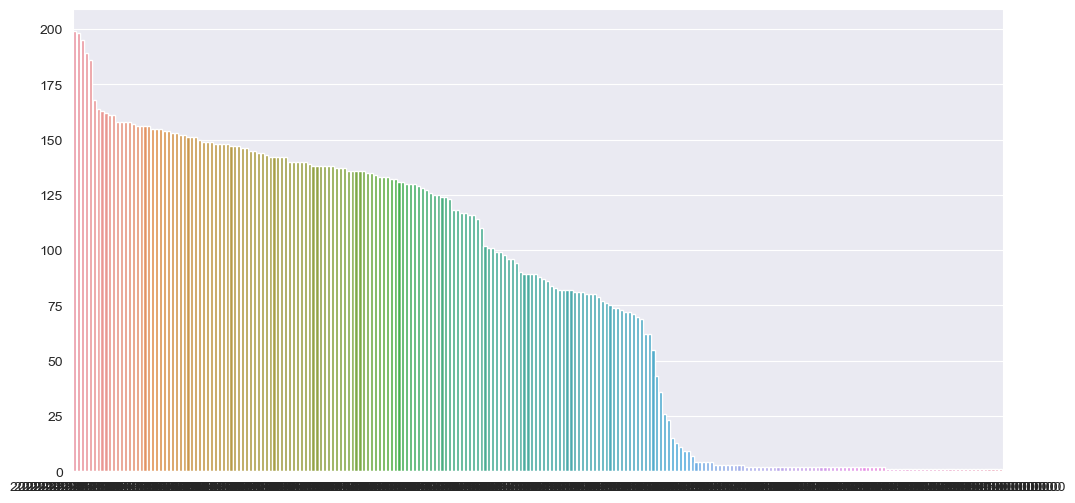

In [68]:
plt.figure(figsize=(12,6))
sns.barplot(x=df_txt['DATA_PUBLICACAO_AUX'].value_counts().index,
              y=df_txt['DATA_PUBLICACAO_AUX'].value_counts().values,
           order=df_txt['DATA_PUBLICACAO_AUX'].value_counts(ascending=False).index) #, palette=paleta_netflix)

In [ ]:
# Proporção por ano adicionado e tipo
plt.figure(figsize=(12,4))
sns.lineplot(data=df_txt, x='DATA_PUBLICACAO_AUX', y='qtd', hue='type', palette=paleta_netflix[:2])
plt.title("Proporção por ano adicionado na Netflix e tipo")
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [33]:
# file_name = "tb_texto_noticias"
# extensao = ".txt"

# df_txt.to_csv(path+file_name+"_tab"+"_utf8"+extensao, sep='\t', encoding='utf-8')
# df_txt.to_csv(path+file_name+extensao, sep='|', encoding='utf-8', index=False)
# df_txt.to_csv(path+file_name+"_bardup"+"_utf8"+extensao, sep=';', encoding='utf-8')

# df_txt.to_csv(path+file_name+"_tab"+"_latin1"+extensao, sep='\t', encoding ='latin1')
# df_txt.to_csv(path+file_name+extensao, sep='|', encoding ='not utf-8', index=False)
# df_txt.to_csv(path+file_name+"_bardup"+"_latin1"+extensao, sep=';', encoding ='latin1')